In [ ]:
! pip install --upgrade pip
! pip install pandas numpy scikit-learn catboost matplotlib seaborn joblib

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, learning_curve, validation_curve, ShuffleSplit, cross_val_score

from catboost import CatBoostClassifier

from sklearn.metrics import (balanced_accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score)

from tqdm.notebook import tqdm

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# This code can be used to train and save the Cat Boost Classifier model in case you need to retrain it:

```py
# data = pd.read_csv("/content/drive/MyDrive/S4/Machine Learning/Project/Android_Malware_Benign.csv")
data = pd.read_csv("https://raw.githubusercontent.com/sam-mg/Xandronyx.ML/refs/heads/main/Android%20Malware%20Legit.csv")
print("Total Data Count: ", len(data))
print("Original Data Split: ")
data['Label'].value_counts()

# Total Data Count:  4464
# Original Data Split: 
# Label
# Malware    2533
# Legit      1931
# Name: count, dtype: int64

TARGET = 'Label'
SEED = 2
TEST_SIZE = 0.3

X = data.drop(columns=[TARGET])
y = data[TARGET]

class_counts = y.value_counts()
print("Class Distribution (Counts):")
print(class_counts)

# Class Distribution (Counts):
# Label
# Malware    2533
# Legit      1931
# Name: count, dtype: int64

class_percentages = y.value_counts(normalize=True) * 100
print("\nClass Distribution (Percentages):")
print(class_percentages.round(2))

# Class Distribution (Percentages):
# Label
# Malware    56.74
# Legit      43.26
# Name: proportion, dtype: float64

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = TEST_SIZE, random_state = SEED, stratify = y)

print(f"y_train: {Counter(y_train)}")
print(f"y_test: {Counter(y_test)}")

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# y_train: Counter({'Malware': 1773, 'Legit': 1351})
# y_test: Counter({'Malware': 760, 'Legit': 580})

model = CatBoostClassifier(random_state = SEED, auto_class_weights = 'Balanced', verbose = 0)
model.fit(X_train.to_numpy(dtype = np.float32), y_train)

joblib.save_model("Model/Cat Boost Classifier.cbm")

joblib.dump((X_train, X_test, y_train, y_test, le), "Dataset Split/Cat Boost Classifier.pkl")
```

To load the saved model, use:
```py
model = CatBoostClassifier()
model.load_model('Model/Cat Boost Classifier.cbm')
X_train, X_test, y_train, y_test, le = joblib.load("Dataset Split/Cat Boost Classifier.pkl")
```

In [12]:
model = CatBoostClassifier()
model.load_model('Model/Cat Boost Classifier.cbm')
X_train, X_test, y_train, y_test, le = joblib.load("Dataset Split/Cat Boost Classifier.pkl")

In [13]:
y_pred_train = model.predict(X_train.to_numpy(dtype = np.float32))
y_pred_test = model.predict(X_test.to_numpy(dtype = np.float32))

score_train = balanced_accuracy_score(y_train, y_pred_train)
score_test = balanced_accuracy_score(y_test, y_pred_test)

print('Accuracy Train:', score_train , '\nAccuracy Test:', score_test)

Accuracy Train: 0.9798899772598518 
Accuracy Test: 0.9565335753176043


In [14]:
y_pred_train_final = model.predict(X_train.to_numpy(dtype = np.float32))
y_pred_test_final = model.predict(X_test.to_numpy(dtype = np.float32))

y_pred_prob_train = model.predict_proba(X_train.to_numpy(dtype = np.float32))[:,1]
y_pred_prob_test = model.predict_proba(X_test.to_numpy(dtype = np.float32))[:,1]

In [15]:
print("Train Report")
print(classification_report(y_train, y_pred_train_final, target_names = le.classes_))
print("\n")
print("Test Report")
print(classification_report(y_test, y_pred_test_final, target_names = le.classes_))

Train Report
              precision    recall  f1-score   support

       Legit       0.96      0.99      0.98      1351
     Malware       0.99      0.97      0.98      1773

    accuracy                           0.98      3124
   macro avg       0.98      0.98      0.98      3124
weighted avg       0.98      0.98      0.98      3124



Test Report
              precision    recall  f1-score   support

       Legit       0.95      0.96      0.95       580
     Malware       0.97      0.96      0.96       760

    accuracy                           0.96      1340
   macro avg       0.96      0.96      0.96      1340
weighted avg       0.96      0.96      0.96      1340



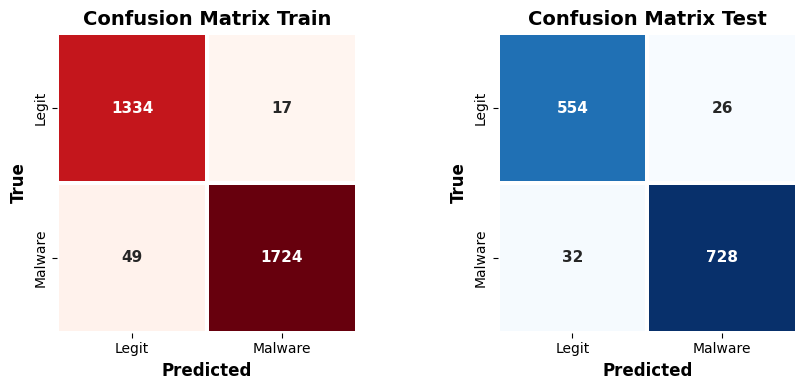

In [16]:
cf_mx_train = confusion_matrix(y_train, y_pred_train_final)
cf_mx_test = confusion_matrix(y_test, y_pred_test_final)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, linewidths = 1.5, fmt = '', xticklabels = le.classes_, yticklabels = le.classes_, cbar = False, square = True, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, linewidths = 1.5, fmt = '', xticklabels = le.classes_, yticklabels = le.classes_, cbar = False, square = True, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 14, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

In [17]:
def plot_learning_curve(model, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', label='Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

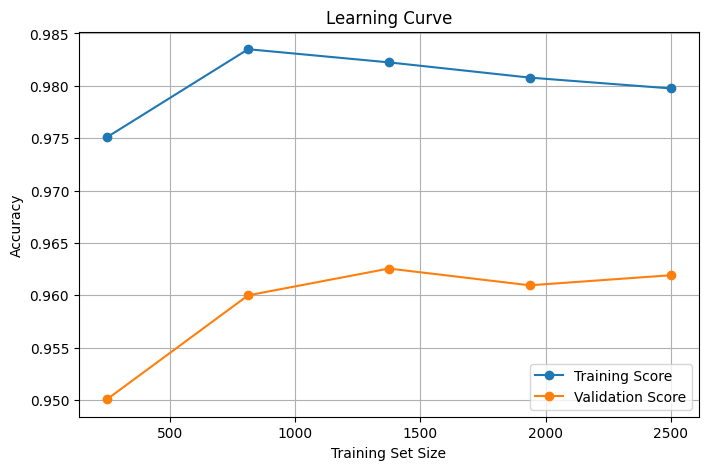

In [18]:
plot_learning_curve(model, X_train.to_numpy(dtype=np.float32), y_train, cv=5, scoring='accuracy')

In [19]:
def plot_validation_curve(model, X, y, param_name, param_range, cv=5, scoring='accuracy'):
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(param_range, train_mean, 'o-', label='Training Score')
    plt.plot(param_range, test_mean, 'o-', label='Validation Score')
    plt.title(f'Validation Curve for {param_name}')
    plt.xlabel(param_name)
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

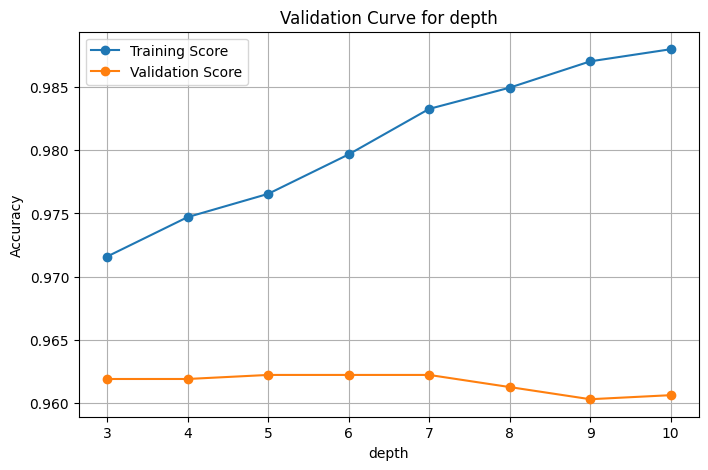

In [20]:
plot_validation_curve(model, X_train.to_numpy(dtype=np.float32), y_train, param_name='depth', param_range=[3, 4, 5, 6, 7, 8, 9, 10], cv=5, scoring='accuracy')

In [21]:
def plot_score_histogram(model, X, y):
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    plt.figure(figsize=(7,4))
    plt.hist(scores, bins=10, edgecolor='black', alpha=0.7)
    plt.title('Model Score Distribution (ShuffleSplit)')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    print(f"Mean Score: {np.mean(scores):.3f} | Std Dev: {np.std(scores):.3f}")

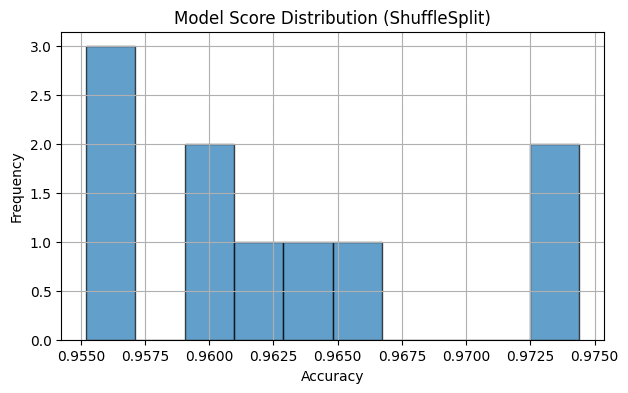

Mean Score: 0.963 | Std Dev: 0.006


In [22]:
plot_score_histogram(model, X_train.to_numpy(dtype=np.float32), y_train)